<a href="https://colab.research.google.com/github/Mcube100/Deep_Learning_Projects_for_Coders/blob/main/fastAI_Computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Imports all functions from fastai.vision.all for computer vision tasks
from fastai.vision.all import *

In [4]:
# Download and extract the dataset of pet images from the given URL
path = untar_data(URLs.PETS)

In [5]:
# List the contents (files and directories) of the 'path' directory
path.ls()

(#2) [Path('/root/.fastai/data/oxford-iiit-pet/annotations'),Path('/root/.fastai/data/oxford-iiit-pet/images')]

In [6]:
# Get a list of file paths for all the images in the 'images' directory within 'path'
files = get_image_files(path/"images")

# Calculate the total number of image files found
len(files)


7390

In [7]:
# Retrieve the file paths of the first and seventh image in the 'files' list
files[0],files[6]

(Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_154.jpg'),
 Path('/root/.fastai/data/oxford-iiit-pet/images/keeshond_150.jpg'))

In [8]:
# Define a function 'label_func' that returns True if the first character of the file name is uppercase, indicating it's a pet name, otherwise False
def label_func(f): return f[0].isupper()

In [9]:
# Create a DataLoaders object for image classification tasks using the provided dataset path, file paths, and label function,
# with image resizing to 224x224 pixels
dls = ImageDataLoaders.from_name_func(path, files, label_func, item_tfms=Resize(224))

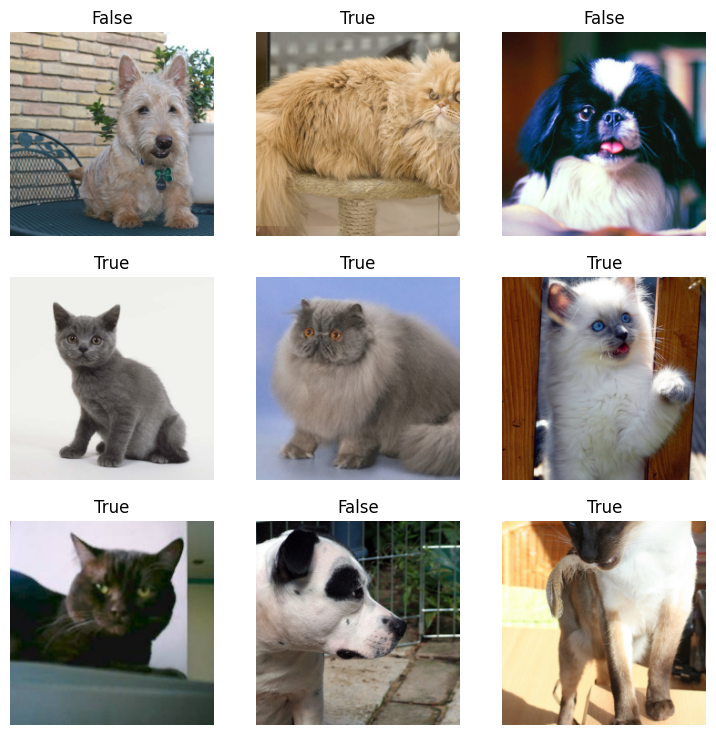

In [10]:
#We can then check if everything looks okay with the show_batch method (True is for cat, False is for dog):
dls.show_batch()

In [11]:
# Create a vision learner using the provided DataLoaders object, using the ResNet34 architecture,
# and measuring performance with error_rate metric
learn = vision_learner(dls, resnet34, metrics=error_rate)

# Fine-tune the model for 1 epoch
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 129MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.148545,0.032181,0.008796,00:43


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch,train_loss,valid_loss,error_rate,time
0,0.050659,0.013053,0.005413,00:45


In [12]:
# Make a prediction on the first image file in the 'files' list using the trained model
learn.predict(files[0])

('False', tensor(0), tensor([1.0000e+00, 3.0468e-06]))

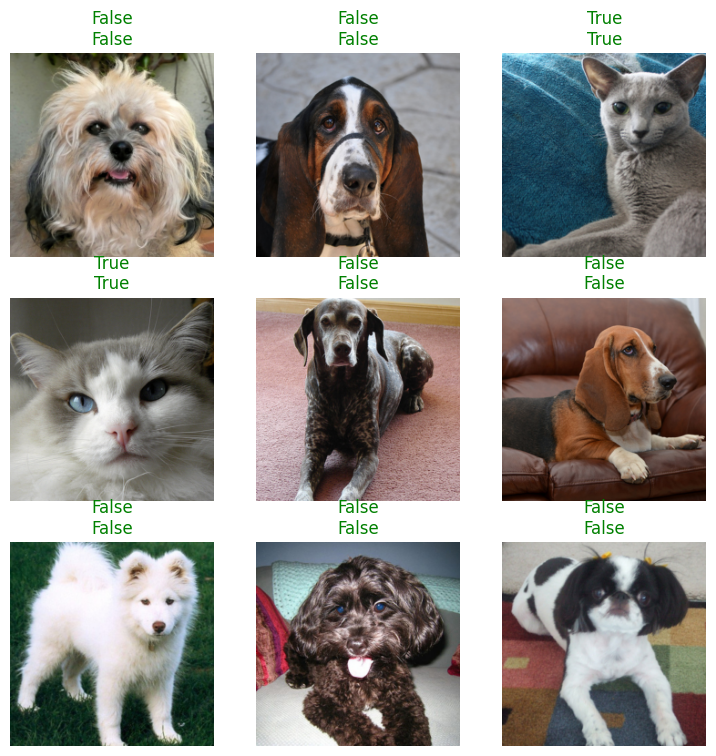

In [13]:
# Display the results of model predictions on the validation set
learn.show_results()

# Classifying breeds

To label our data with the breed name, we will use a regular expression to extract it from the filename. Looking back at a filename, we have:

In [14]:
files[0].name

'staffordshire_bull_terrier_154.jpg'

so the class is everything before the last _ followed by some digits. A regular expression that will catch the name is thus:

In [15]:
pat = r'^(.*)_\d+.jpg'

Since it’s pretty common to use regular expressions to label the data (often, labels are hidden in the file names), there is a factory method to do just that:

In [16]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(224))

Like before, we can then use show_batch to have a look at our data:

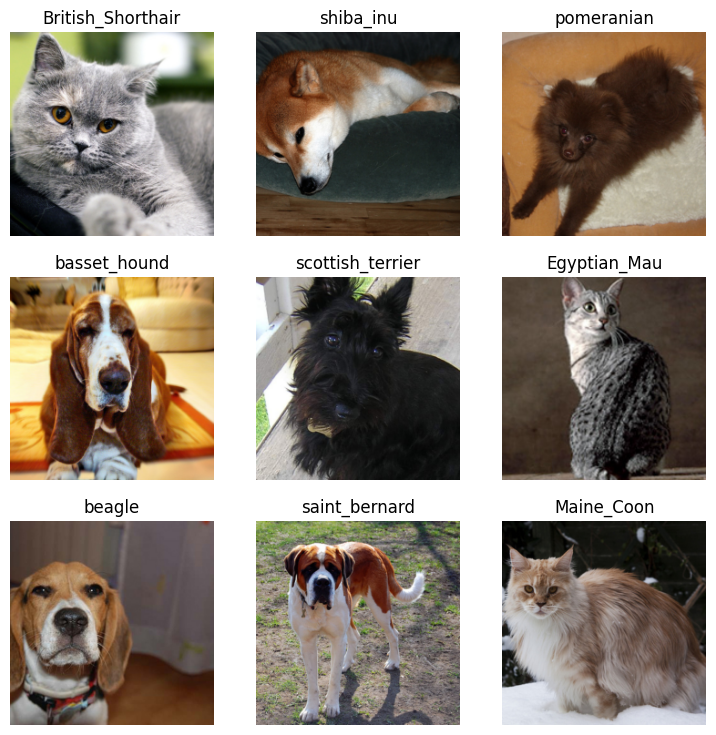

In [17]:
dls.show_batch()

Since classifying the exact breed of cats or dogs amongst 37 different breeds is a harder problem, we will slightly change the definition of our DataLoaders to use data augmentation:

In [18]:
dls = ImageDataLoaders.from_name_re(path, files, pat, item_tfms=Resize(460),
                                    batch_tfms=aug_transforms(size=224))

This time we resized to a larger size before batching, and we added batch_tfms. aug_transforms is a function that provides a collection of data augmentation transforms with defaults we found that perform well on many datasets. You can customize these transforms by passing appropriate arguments to aug_transforms.

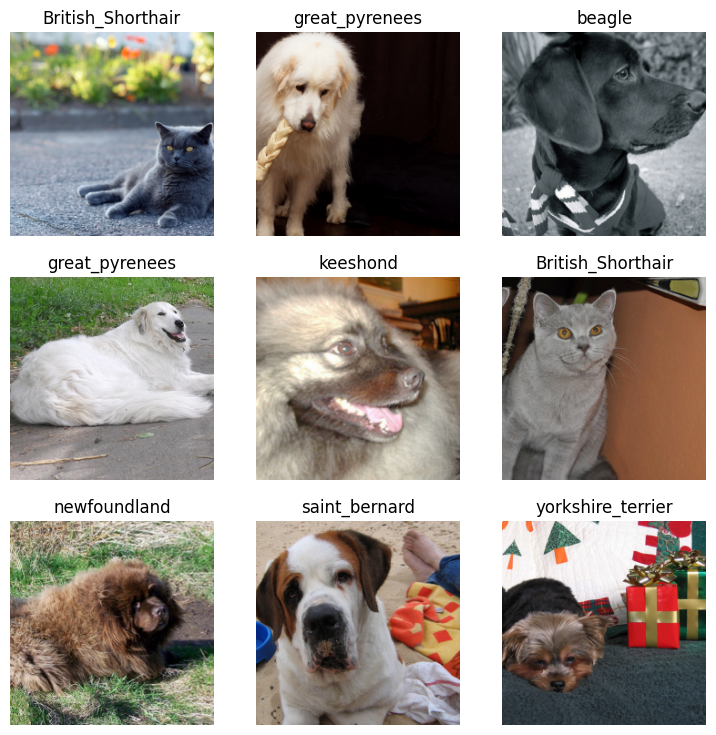

In [19]:
dls.show_batch()

We can then create our Learner exactly as before and train our model.

In [20]:
learn = vision_learner(dls, resnet34, metrics=error_rate)

We used the default learning rate before, but we might want to find the best one possible. For this, we can use the learning rate finder:

SuggestedLRs(valley=0.001737800776027143)

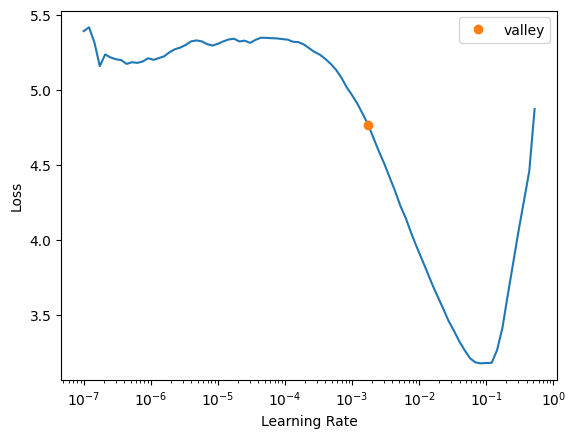

In [21]:
learn.lr_find()

It plots the graph of the learning rate finder and gives us two suggestions (minimum divided by 10 and steepest gradient). Let’s use 3e-3 here. We will also do a bit more epochs:

In [22]:
learn.fine_tune(2, 3e-3)

epoch,train_loss,valid_loss,error_rate,time
0,1.292016,0.355104,0.108254,01:02


epoch,train_loss,valid_loss,error_rate,time
0,0.529757,0.345193,0.105548,01:05
1,0.326713,0.242642,0.071719,01:05
